In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wandb

import os

from bcnf.utils import get_gaussian_kernel, partconv1d, get_dir

In [2]:
wandb.login()

api = wandb.Api()
runs = {
    'trajectory_TRF_small': api.run("/balisticcnf/bcnf-test/runs/dclcpqty"),
    'trajectory_LSTM_small': api.run("/balisticcnf/bcnf-test/runs/wpzsbwsb"),
    'trajectory_FC_small': api.run("/balisticcnf/bcnf-test/runs/xfkfo69v"),
    'trajectory_TRF_large': api.run("/balisticcnf/bcnf-test/runs/hnj6npt2"),
    'trajectory_FC_large': api.run("/balisticcnf/bcnf-test/runs/v83m23td"),
    'trajectory_LSTM_large': api.run("/balisticcnf/bcnf-test/runs/d0xk0blq"),
}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: psaegert (bcnf). Use `wandb login --relogin` to force relogin


In [3]:
histories = {k: v.history() for k, v in runs.items()}

In [4]:
histories['trajectory_TRF_small'].keys()

Index(['z_mean_std_fold_-1', '_step', 'time_fold_-1', 'epoch', 'lr_fold_-1',
       'val_loss_fold_-1', 'z_mean_mean_fold_-1',
       'distance_to_last_best_val_loss_fold_-1', '_runtime',
       'z_std_std_fold_-1', 'train_loss_fold_-1', 'z_std_mean_fold_-1',
       '_timestamp'],
      dtype='object')

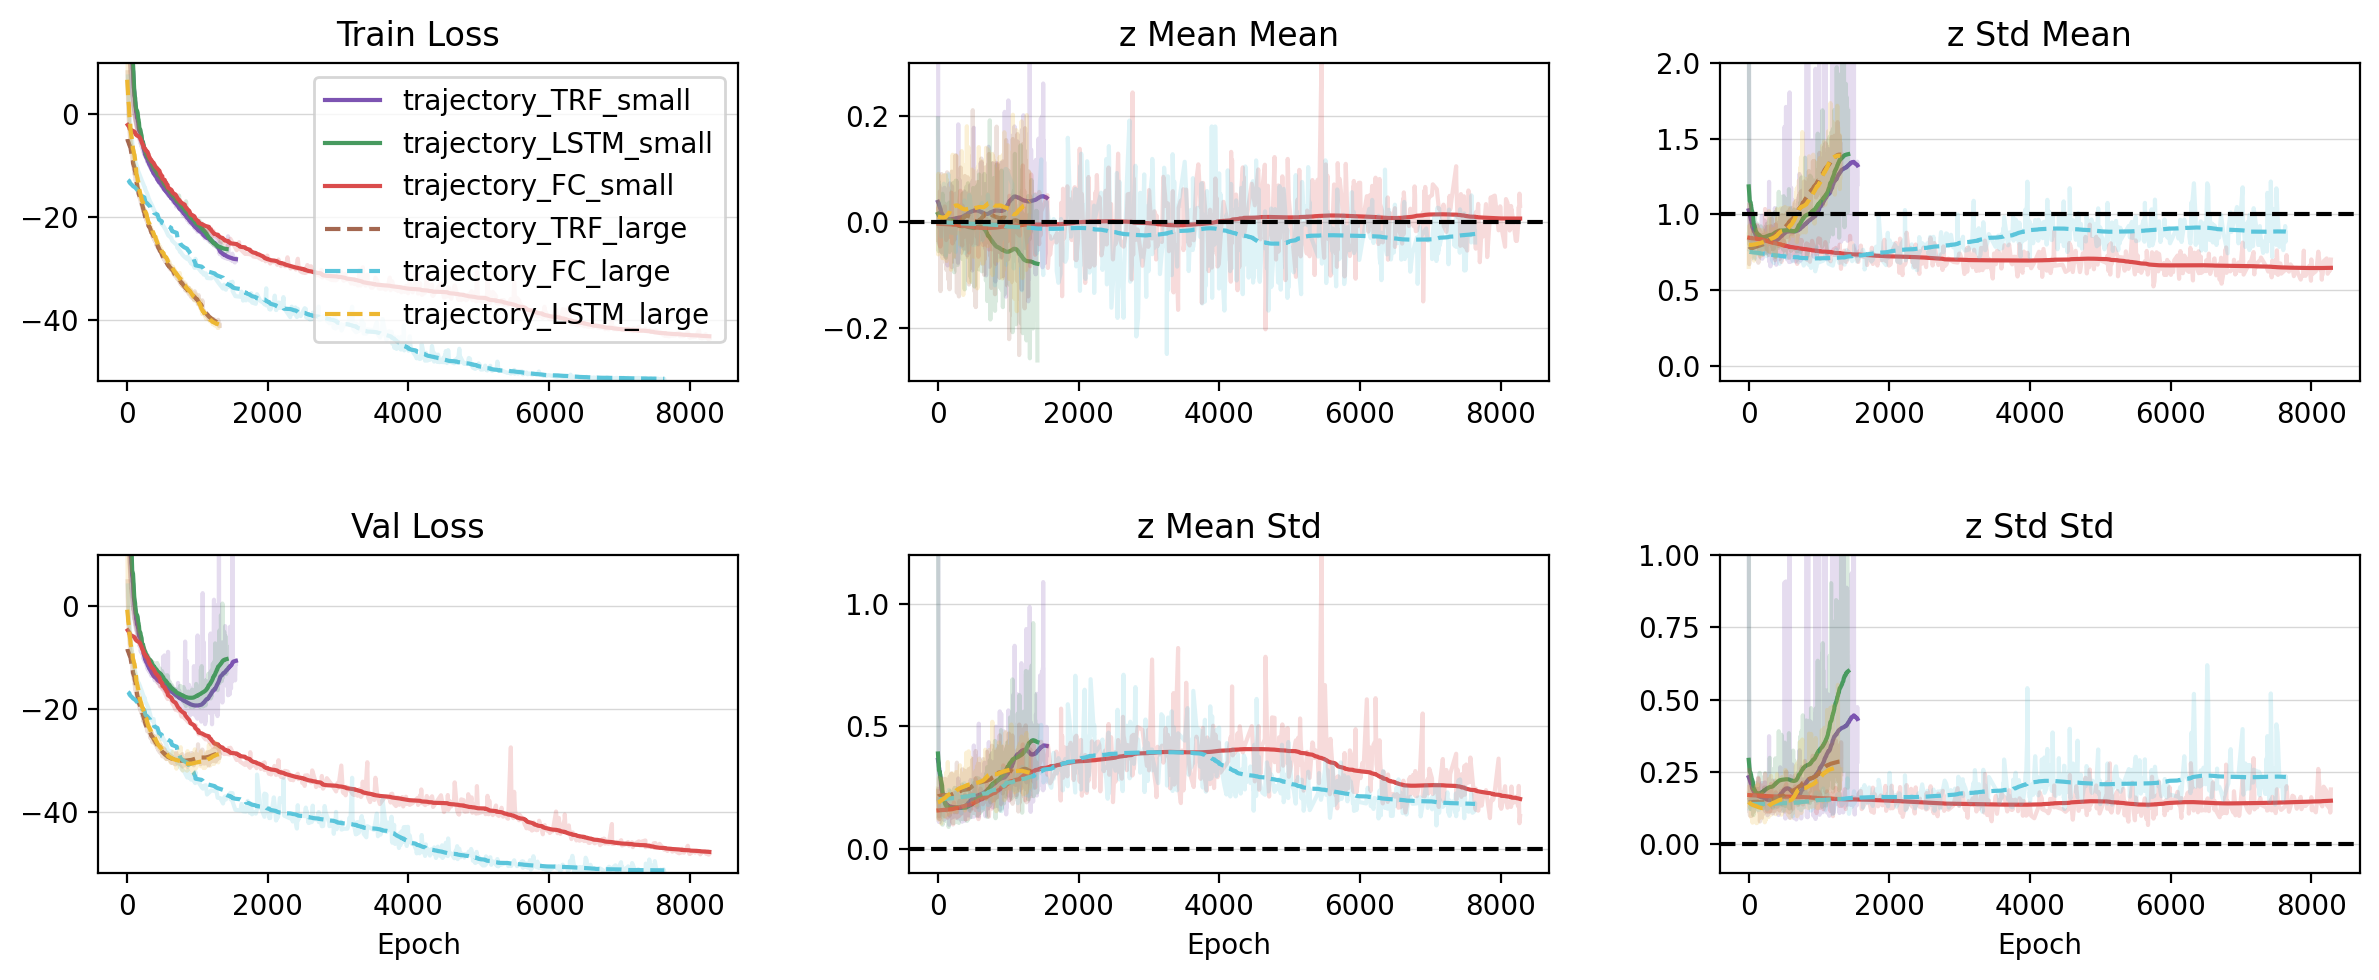

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(12, 5), dpi=200)

for i, (ax, key, key_name, target, ylim) in enumerate(
    zip(axes.flatten(),
        ['train_loss_fold_-1', 'z_mean_mean_fold_-1', 'z_std_mean_fold_-1', 'val_loss_fold_-1', 'z_mean_std_fold_-1', 'z_std_std_fold_-1'],
        ['Train Loss', 'z Mean Mean', 'z Std Mean', 'Val Loss', 'z Mean Std', 'z Std Std'],
        [None, 0, 1, None, 0, 0],
        [(-52, 10), (-.3, .3), (-.1, 2), (-52, 10), (-.1, 1.2), (-.1, 1)]
        )):
    for (name, history), color, linestyle in zip(
        histories.items(),
        ['7d54b2', '479a5f', 'da4c4c', 'a46750', '5bc5db', 'edb732'],
        ['-', '-', '-', '--', '--', '--']):
        ax.plot(history['epoch'], history[key], alpha=0.2, color='#' + color)
        ax.plot(history['epoch'], partconv1d(data=np.array(history[key]), kernel=get_gaussian_kernel(20)), label=name, color='#' + color, linestyle=linestyle)

    ax.set_ylim(ylim)

    if target is not None:
        ax.axhline(target, color='black', linestyle='--')
    ax.set_title(key_name)
    ax.grid(axis='y', alpha=0.5, linewidth=0.5)

    if i in [3, 4, 5]:
        ax.set_xlabel('Epoch')

axes[0, 0].legend()

fig.tight_layout(h_pad=3, w_pad=3)

plt.savefig(os.path.join(get_dir('results', 'logging', create=True), 'train_trajectory_comparison.png'))

In [15]:
losses = {name: pd.DataFrame(history).tail(1)[['train_loss_fold_-1', 'val_loss_fold_-1']] for name, history in histories.items()}

results_df = pd.concat(losses, axis=0)

results_df

,,train_loss_fold_-1,val_loss_fold_-1
trajectory_TRF_small,499,-28.554552,-11.182146
trajectory_LSTM_small,499,-26.677588,-7.937801
trajectory_FC_small,499,-43.686664,-48.199781
trajectory_TRF_large,499,-41.211030,-28.868503
trajectory_FC_large,499,-51.602973,-51.942801
trajectory_LSTM_large,499,-41.056222,-29.034296
